In [2]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/home/ubuntu/frameshift-1/data"

In [3]:
edist = pd.read_csv(f"{data_dir}/Tahoe96M_edist_matrix_within_plate.tsv", index_col=0, sep='\t')
edist.head(2)

,"[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]","[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]","[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]","[('(S)-Crizotinib', 0.05, 'uM')]","[('(S)-Crizotinib', 0.5, 'uM')]","[('(S)-Crizotinib', 5.0, 'uM')]","[('18β-Glycyrrhetinic acid', 0.05, 'uM')]","[('18β-Glycyrrhetinic acid', 0.5, 'uM')]","[('18β-Glycyrrhetinic acid', 5.0, 'uM')]","[('4EGI-1', 0.05, 'uM')]",...,"[('palbociclib', 5.0, 'uM')]","[('venetoclax', 0.05, 'uM')]","[('venetoclax', 0.5, 'uM')]","[('venetoclax', 5.0, 'uM')]","[('vincristine', 0.05, 'uM')]","[('vincristine', 0.5, 'uM')]","[('vincristine', 5.0, 'uM')]","[('γ-Oryzanol', 0.05, 'uM')]","[('γ-Oryzanol', 0.5, 'uM')]","[('γ-Oryzanol', 5.0, 'uM')]"
cell_line,,,,,,,,,,,,,,,,,,,,,
A549,1.512713,0.722098,0.414523,0.878519,0.081575,1.602780,0.108720,1.006570,0.822553,0.25720,...,1.886109,0.847928,1.420249,7.662991,0.610269,6.679521,2.494245,0.347540,0.067947,1.303884
COLO 205,0.910699,0.901802,0.357076,0.785834,0.122920,0.998614,0.245093,0.942391,0.697818,0.41566,...,0.783737,0.470903,0.779484,3.343617,1.693857,5.234885,3.152886,0.226383,0.051400,0.318881


In [4]:
drug_meta = edist.columns.to_frame().rename(columns={0: "drug_longfmt"})
#replace propanediol, hydrate to remove the space
drug_meta['drug_longfmt'] = drug_meta['drug_longfmt'].str.replace("propanediol, hydrate", "propanediol,hydrate")

drug_meta = drug_meta['drug_longfmt'].str.replace("'", "").str.replace(", uM)]", "").str.replace('[(', '').str.split(", ", expand=True)
drug_meta.columns = ["drug", "dose"]
drug_meta.head(3)

,drug,dose
"[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]",(R)-Verapamil (hydrochloride),0.05
"[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]",(R)-Verapamil (hydrochloride),0.5
"[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]",(R)-Verapamil (hydrochloride),5.0


In [5]:
# drug_meta5 = drug_meta[(drug_meta['drug'] == "DMSO_TF") | (drug_meta['dose'] == "5.0")]
drug_meta5 = drug_meta[(drug_meta['dose'] == "5.0")]
drug_meta5.sort_values('dose')

,drug,dose
"[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]",(R)-Verapamil (hydrochloride),5.0
"[('Paclitaxel', 5.0, 'uM')]",Paclitaxel,5.0
"[('PH-797804', 5.0, 'uM')]",PH-797804,5.0
"[('PF-06260933', 5.0, 'uM')]",PF-06260933,5.0
"[('Oxaprozin', 5.0, 'uM')]",Oxaprozin,5.0
...,...,...
"[('Diphenhydramine', 5.0, 'uM')]",Diphenhydramine,5.0
"[('Dinaciclib', 5.0, 'uM')]",Dinaciclib,5.0
"[('Dimethyl fumarate', 5.0, 'uM')]",Dimethyl fumarate,5.0
"[('ERK5-IN-2', 5.0, 'uM')]",ERK5-IN-2,5.0


In [6]:
#get the dose of 5 only
edist5 = edist.loc[:, drug_meta5.index]
edist5.columns = drug_meta5['drug']
edist5.head(3)


drug,(R)-Verapamil (hydrochloride),(S)-Crizotinib,18β-Glycyrrhetinic acid,4EGI-1,5-Azacytidine,5-Fluorouracil,8-Hydroxyquinoline,9-ING-41,APTO-253,AT7519,...,Vortioxetine,XRK3F2,Zileuton,c-Kit-IN-1,crizotinib,olaparib,palbociclib,venetoclax,vincristine,γ-Oryzanol
cell_line,,,,,,,,,,,,,,,,,,,,,
A549,0.414523,1.602780,0.822553,0.604181,0.215496,1.264086,0.254773,2.132352,0.226501,0.309678,...,1.021167,2.533169,0.159264,4.845418,1.714201,0.789772,1.886109,7.662991,2.494245,1.303884
COLO 205,0.357076,0.998614,0.697818,0.561836,0.517479,0.429730,0.302023,2.327751,0.292322,0.615865,...,0.565004,2.939890,0.131060,2.140641,1.977494,0.376860,0.783737,3.343617,3.152886,0.318881
HT-29,0.366198,1.423640,0.806040,1.063001,0.630798,0.666058,0.449617,2.477781,0.431455,0.662499,...,0.688498,3.724571,0.192667,5.069367,3.111637,0.477851,0.261656,2.368669,3.488894,0.361513


In [7]:
# edist5.isna().sum(axis=1).sort_values()
#drop cell lines that have NA
print(edist5.shape)
edist5 = edist5.dropna(axis=0)
print(edist5.shape)

(50, 379)
(48, 379)


/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


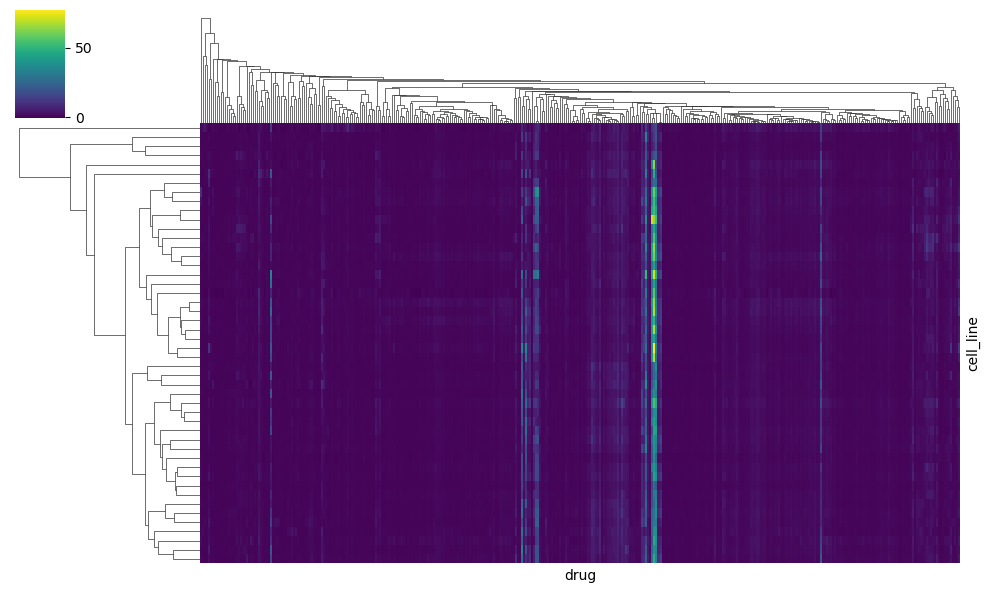

In [54]:
# sns.clustermap(np.log10(edist5+1), cmap="viridis", figsize=(10, 6), metric='cosine', xticklabels=False, yticklabels=False)
sns.clustermap(edist5, cmap="viridis", figsize=(10, 6), metric='cosine', xticklabels=False, yticklabels=False)

/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


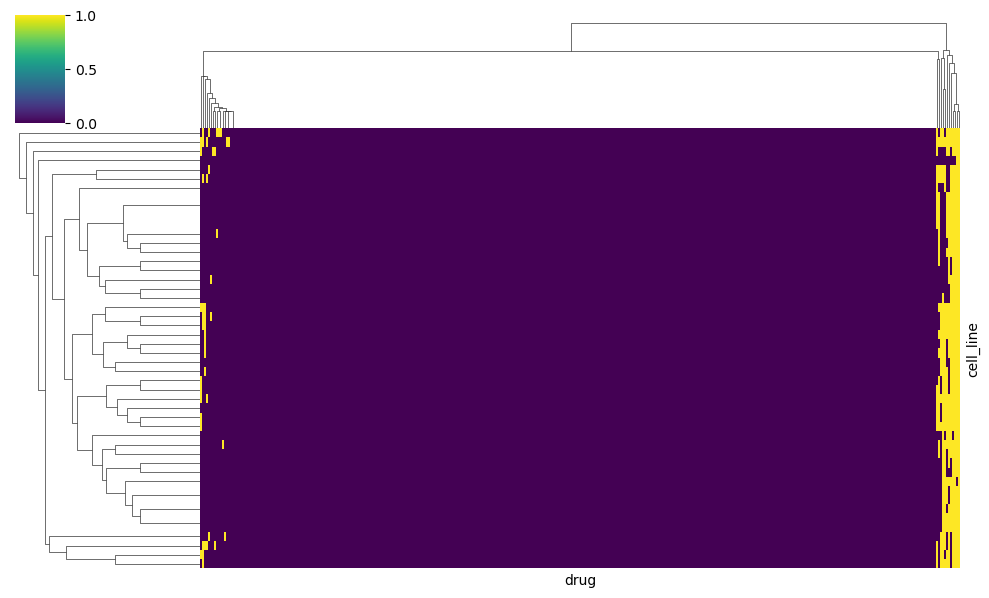

In [68]:
sns.clustermap((edist5 > 10).astype(float), cmap="viridis", figsize=(10, 6), metric='euclidean', xticklabels=False, yticklabels=False)

In [8]:
path = "/home/ubuntu/frameshift-1/data/metadata/drug_metadata.parquet"
d_annot = pd.read_parquet(path, engine='pyarrow')
d_annot.head()

,drug,targets,moa-broad,moa-fine,human-approved,clinical-trials,gpt-notes-approval,canonical_smiles,pubchem_cid
0,Talc,None,unclear,unclear,yes,yes,Talc used in pharma and cosmetics; safety unde...,[OH-].[OH-].[O-][Si]12O[Si]3(O[Si](O1)(O[Si](O...,165411828.0
1,Bortezomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma and mantle cell ...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0
2,Ixazomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment.,B(C(CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O,25183872.0
3,Ixazomib citrate,"PSMB1, PSMB2, PSMB5",inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment as par...,B1(OC(=O)C(O1)(CC(=O)O)CC(=O)O)C(CC(C)C)NC(=O)...,56844015.0
4,Lactate (calcium),None,unclear,unclear,yes,yes,"Used in medical settings, but not specifically...",C.CC(C(=O)[O-])O.[Ca+2],168311648.0


In [9]:
prop_has_effect = (edist5 > 10).mean().sort_values().to_frame()
prop_has_effect['moa-fine'] = d_annot.set_index('drug')['moa-fine']
prop_has_effect

,0,moa-fine
drug,,
(R)-Verapamil (hydrochloride),0.000000,unclear
Oxaliplatin,0.000000,DNA synthesis/repair inhibitor
Osimertinib (mesylate),0.000000,EGFR/ERBB inhibitor
Ornidazole,0.000000,unclear
Orlistat,0.000000,unclear
...,...,...
PH-797804,0.791667,Other MAPK inhibitor
Harringtonine,0.958333,Protein synthesis inhibitor
Dinaciclib,0.979167,CDK inhibitor


In [11]:
# prop_has_effect.loc['C']

In [12]:
prop_has_effect.tail(50)

,0,moa-fine
drug,,
Decitabine,0.000000,DNA methyltransferase inhibitor
APTO-253,0.000000,unclear
Darolutamide,0.000000,Androgen receptor antagonist
Diphenhydramine,0.000000,unclear
Darinaparsin,0.000000,unclear
Docetaxel (Trihydrate),0.000000,Microtubule inhibitor
"Dapagliflozin ((2S)-1,2-propanediol,hydrate)",0.000000,NaN
Encorafenib,0.000000,RAF inhibitor
Elimusertib hydrochloride,0.000000,unclear


In [79]:
edist5.loc[(edist5 > 10)['Dabrafenib'], 'Dabrafenib']

cell_line
MIA PaCa-2    10.194635
Name: Dabrafenib, dtype: float64

In [13]:
doi = ['Lonafarnib','BI-3406','RMC-6236','Adagrasib','Celecoxib', 'Homoharringtonine', 'Dinaciclib']
prop_has_effect.loc[doi]
# prop_has_effect

drug
Lonafarnib           0.645833
BI-3406              0.000000
RMC-6236             0.333333
Adagrasib            0.000000
Celecoxib            0.000000
Homoharringtonine    1.000000
Dinaciclib           1.000000
dtype: float64

In [14]:
cloi = ['SW48', 'RKO', 'LS 180', 'HCT15']
edist5.loc[cloi, doi]

drug,Lonafarnib,BI-3406,RMC-6236,Adagrasib,Celecoxib,Homoharringtonine,Dinaciclib
cell_line,,,,,,,
SW48,20.418649,1.043858,5.367936,0.707020,0.250143,38.074064,21.514979
RKO,20.733644,0.875010,3.943867,0.762600,0.059217,26.315511,30.861954
LS 180,11.402279,2.569433,5.855951,0.675581,0.199941,28.318284,21.259007
HCT15,3.105541,1.944487,4.946523,0.589459,0.406036,39.688681,33.650005


### stratifying with mutation data

In [13]:
## open parquet in python
path = "/home/ubuntu/frameshift-1/data/cell_line_metadata.parquet"
cl_meta = pd.read_parquet(path, engine='pyarrow')
cl_meta

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor
...,...,...,...,...,...,...,...,...,...,...
995,LOX-IMVI,ACH-000750,CVCL_1381,Skin,ARID1A,Het,Stopgain,p.Q1212*,LoF,Suppressor
996,LOX-IMVI,ACH-000750,CVCL_1381,Skin,BRAF,Het,Missense,p.V600E,GoF,Oncogene
997,LOX-IMVI,ACH-000750,CVCL_1381,Skin,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
998,LOX-IMVI,ACH-000750,CVCL_1381,Skin,NF1,Het,Stopgain,p.Q1174*,LoF,Suppressor


In [14]:
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(edist5.index)]
kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")
# kras_driven

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
392,MIA PaCa-2,ACH-000601,CVCL_0428,Pancreas,KRAS,Hom,Missense,p.G12C,GoF,Oncogene
548,HOP62,ACH-000861,CVCL_1285,Lung,KRAS,Het,Missense,p.G12C,GoF,Oncogene
971,NCI-H23,ACH-000900,CVCL_1547,Lung,KRAS,Het,Missense,p.G12C,GoF,Oncogene
978,NCI-H1792,ACH-000496,CVCL_1495,Lung,KRAS,Het,Missense,p.G12C,GoF,Oncogene
989,NCI-H2030,ACH-000521,CVCL_1517,Lung,KRAS,Hom,Missense,p.G12C,GoF,Oncogene


In [16]:
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'").query("Organ == 'Lung'")['cell_name']
not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'").query("Organ == 'Lung'")['cell_name']
len(g12c), len(not_g12c)

(4, 7)

In [17]:
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")
#subset so that it exists in the e-distance
not_kras_driven = not_kras_driven[not_kras_driven['cell_name'].isin(edist5.index)]
#drop any cell lines that have BRAF
braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated").query("Organ == 'Lung'")['cell_name'].unique()

len(krasNo_brafNo), len(g12c), len(not_g12c)

(2, 4, 7)

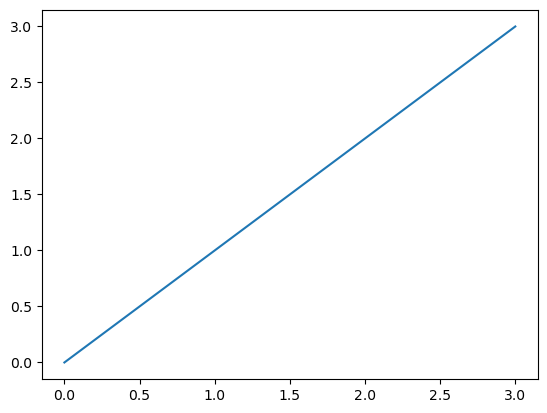

In [20]:
plt.plot([0,1,2,3], [0,1,2,3])

In [18]:
nominated = list(krasNo_brafNo[0:2]) + list(g12c[0:2]) + list(not_g12c[0:2])
# nominated = list(krasNo_brafNo) + list(g12c) + list(not_g12c)
nominated

['NCI-H661', 'SW 1271', 'HOP62', 'NCI-H23', 'A549', 'SHP-77']

In [19]:
edist5.index[edist5.index.isin(nominated)]

Index(['A549', 'SHP-77', 'HOP62', 'NCI-H661', 'SW 1271', 'NCI-H23'], dtype='object', name='cell_line')

In [114]:
drugs = ['RMC-6236','Adagrasib','Celecoxib', 'Homoharringtonine', 'Dinaciclib', 'DMSO_TF']
drugs

['RMC-6236',
 'Adagrasib',
 'Celecoxib',
 'Homoharringtonine',
 'Dinaciclib',
 'DMSO_TF']

In [85]:
cell_picked = ['SW48', 'RKO', 'LS180', 'HCT15']
cl_meta[cl_meta['cell_name'].isin(cell_picked)]

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
336,RKO,ACH-000943,CVCL_0504,Bowel,ACVR2A,Het,Frameshift,p.K437fs,LoF,Suppressor
337,RKO,ACH-000943,CVCL_0504,Bowel,ARID1A,Het,Frameshift,p.D1633fs,LoF,Suppressor
338,RKO,ACH-000943,CVCL_0504,Bowel,ARID1A,Het,Frameshift,p.P1115fs,LoF,Suppressor
339,RKO,ACH-000943,CVCL_0504,Bowel,B2M,Het,Stopgain,p.R117*,LoF,Suppressor
340,RKO,ACH-000943,CVCL_0504,Bowel,BRAF,Het,Missense,p.V600E,GoF,Oncogene
...,...,...,...,...,...,...,...,...,...,...
599,LS 180,ACH-000957,CVCL_0397,Bowel,TGFBR2,Hom,Frameshift,p.K128fs,LoF,Suppressor
600,LS 180,ACH-000957,CVCL_0397,Bowel,WNK2,Het,Missense,p.A1529T,None,Suppressor
601,LS 180,ACH-000957,CVCL_0397,Bowel,WNK2,Het,Frameshift,p.D1638fs,LoF,Suppressor
602,LS 180,ACH-000957,CVCL_0397,Bowel,ZFHX3,Het,Frameshift,p.A3407fs,LoF,Suppressor


In [119]:
drug_longfmt = drug_meta5.query("drug in @drugs").index.tolist() + drug_meta.query("drug == 'DMSO_TF'").index.tolist()
drug_longfmt

["[('Adagrasib', 5.0, 'uM')]",
 "[('Celecoxib', 5.0, 'uM')]",
 "[('Dinaciclib', 5.0, 'uM')]",
 "[('Homoharringtonine', 5.0, 'uM')]",
 "[('RMC-6236', 5.0, 'uM')]",
 "[('DMSO_TF', 0.0, 'uM')]"]

In [82]:
kras_driven['Driver_ProtEffect_or_CdnaEffect'].value_counts()

Driver_ProtEffect_or_CdnaEffect
p.G12D    6
p.G12V    5
p.G12C    5
p.G13D    2
p.Q61H    2
p.G12S    1
p.G12A    1
p.L19F    1
Name: count, dtype: int64

In [ ]:
# KRASG12C
# RAFn

/tmp/ipykernel_32447/1395247711.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_ras_driven_idx = tissue_meta[~cl_meta['cell_name'].isin(ras_driven_idx)]['cell_name'].unique()
/tmp/ipykernel_32447/1395247711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_32447/1395247711.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_ras_driven_idx = tissue_meta[~cl_meta['cell_name'].isin(ras_driven_idx)]['cell_name'].unique()
/tmp/ipykernel_32447/1395247711.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_32447/1395247711.py:10: UserWarning: Boolean Series key will be reindexed to match 

,cell_line,label,drug,edist
0,A549,RAS,Lonafarnib,6.915028
1,SHP-77,RAS,Lonafarnib,1.040128
2,SW 900,RAS,Lonafarnib,5.956018
3,HOP62,RAS,Lonafarnib,15.942005
4,NCI-H1573,RAS,Lonafarnib,16.689606
...,...,...,...,...
86,NCI-H2347,RAS,Dinaciclib,18.821846
87,NCI-H23,RAS,Dinaciclib,20.862343
88,NCI-H1792,RAS,Dinaciclib,36.966498
89,NCI-H2030,RAS,Dinaciclib,14.877853


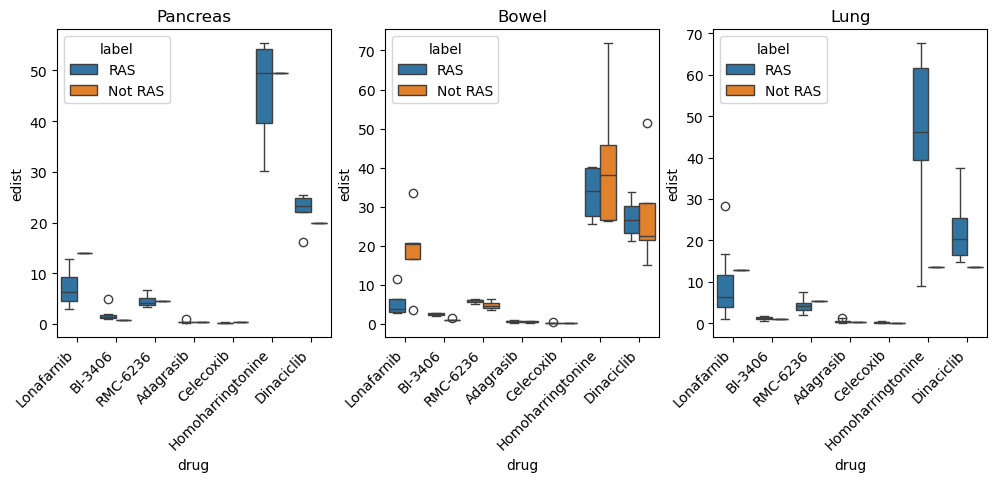

In [41]:
tissues = ['Pancreas', 'Bowel', 'Lung']
nplot = len(tissues)
fig, axs = plt.subplots(1, nplot, figsize=(4*nplot, 4))
for tissue, ax in zip(tissues, axs):
	tissue_meta = cl_meta.query(f"Organ == '{tissue}'")
	tissue_meta = tissue_meta[tissue_meta['cell_name'].isin(edist5.index)]
	ras_idx = tissue_meta['Driver_Gene_Symbol'].str.contains('RAS')

	ras_driven_idx = tissue_meta.loc[ras_idx]['cell_name'].unique()
	not_ras_driven_idx = tissue_meta[~cl_meta['cell_name'].isin(ras_driven_idx)]['cell_name'].unique()

	ras_driven

	ras_edist = edist5.loc[ras_driven_idx, doi]
	ras_edist['label'] = 'RAS'
	not_ras_edist = edist5.loc[not_ras_driven_idx, doi]
	not_ras_edist['label'] = 'Not RAS'

	merged = pd.concat([ras_edist, not_ras_edist])
	merged = merged.reset_index().melt(id_vars=['cell_line', 'label'], var_name='drug', value_name='edist')

	sns.boxplot(x='drug', y='edist', hue='label', data=merged, ax=ax)
	ax.set_title(tissue)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
merged
	# sns.boxplot(x='label', y=doi[0], data=merged, palette=["#FBB4AE", "#BFD3C1"])
	# all_cl = list(ras_driven) + list(not_ras_driven)
	# g = sns.clustermap(edist5.loc[all_cl, doi], cmap="viridis", figsize=(10, 6), metric='cosine',)

# cl_meta.loc[cl_meta['cell_name'].isin(not_ras_driven)]


/tmp/ipykernel_32447/2050992724.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_ras_driven_idx = tissue_meta[~cl_meta['cell_name'].isin(ras_driven_idx)]['cell_name'].unique()
/tmp/ipykernel_32447/2050992724.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


,cell_line,label,drug,edist
0,A549,RAS,Lonafarnib,6.915028
1,SW480,RAS,Lonafarnib,4.650184
2,HS-578T,RAS,Lonafarnib,20.632142
3,LoVo,RAS,Lonafarnib,2.799270
4,SHP-77,RAS,Lonafarnib,1.040128
...,...,...,...,...
331,C32,Not RAS,Dinaciclib,27.970473
332,KATO III,Not RAS,Dinaciclib,21.362455
333,A-172,Not RAS,Dinaciclib,18.905735
334,hTERT-HPNE,Not RAS,Dinaciclib,19.973794


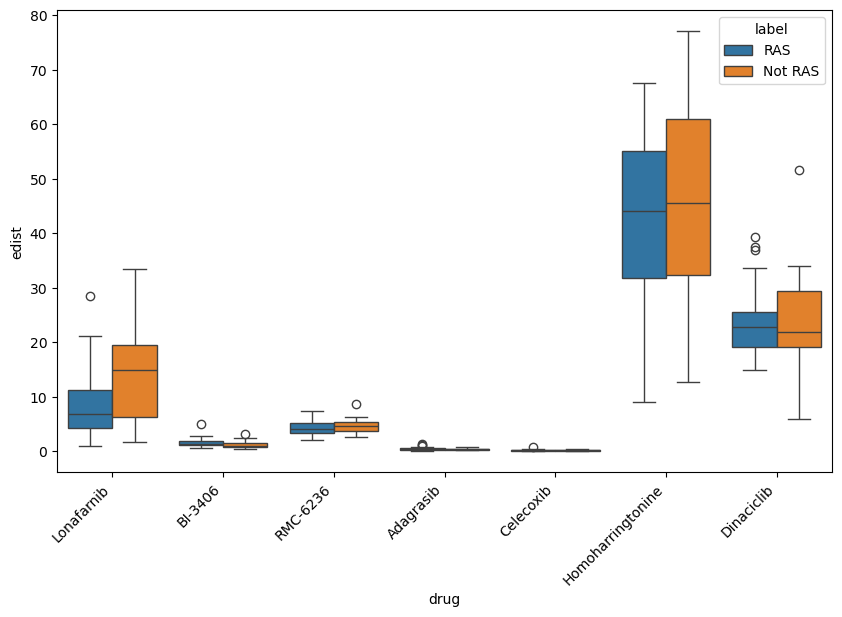

In [65]:
# tissue_meta = cl_meta.query(f"Organ == '{tissue}'")
tissue_meta = cl_meta
tissue_meta = tissue_meta[tissue_meta['cell_name'].isin(edist5.index)]
ras_idx = tissue_meta['Driver_Gene_Symbol'].str.contains('RAS')

ras_driven_idx = tissue_meta.loc[ras_idx]['cell_name'].unique()
not_ras_driven_idx = tissue_meta[~cl_meta['cell_name'].isin(ras_driven_idx)]['cell_name'].unique()

ras_edist = edist5.loc[ras_driven_idx, doi]
ras_edist['label'] = 'RAS'
not_ras_edist = edist5.loc[not_ras_driven_idx, doi]
not_ras_edist['label'] = 'Not RAS'

merged = pd.concat([ras_edist, not_ras_edist])
merged = merged.reset_index().melt(id_vars=['cell_line', 'label'], var_name='drug', value_name='edist')

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='drug', y='edist', hue='label', data=merged, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
merged

In [66]:
cl_meta.query("Driver_Gene_Symbol == 'KRAS'")['Driver_Mech_InferDM'].value_counts()

Driver_Mech_InferDM
GoF    54
Name: count, dtype: int64

In [58]:
cl2tissue = cl_meta[['cell_name', 'Organ']].drop_duplicates().set_index('cell_name')

In [80]:
cl2tissue.head(30)

,Organ
cell_name,
A549,Lung
HOP-92,Lung
HMVII,Vulva/Vagina
Hs 936.T(C1),Skin
MM485,Skin
MM415,Skin
MCF-7,Breast
SK-MEL-30,Skin
SW620,Bowel


In [62]:
cl2tissue.loc[edist5['RMC-6236'].sort_values(ascending=False).index]

,Organ
cell_line,
H4,CNS/Brain
A-427,Lung
AsPC-1,Pancreas
HT-29,Bowel
SW480,Bowel
SNU-1,Esophagus/Stomach
KATO III,Esophagus/Stomach
LoVo,Bowel
NCI-H460,Lung


,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor
...,...,...,...,...,...,...,...,...,...,...
995,LOX-IMVI,ACH-000750,CVCL_1381,Skin,ARID1A,Het,Stopgain,p.Q1212*,LoF,Suppressor
996,LOX-IMVI,ACH-000750,CVCL_1381,Skin,BRAF,Het,Missense,p.V600E,GoF,Oncogene
997,LOX-IMVI,ACH-000750,CVCL_1381,Skin,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
998,LOX-IMVI,ACH-000750,CVCL_1381,Skin,NF1,Het,Stopgain,p.Q1174*,LoF,Suppressor


In [45]:
# cl_meta
cl_meta.loc[edist5['RMC-6236'].sort_values(ascending=False)]

KeyError: "None of [Index([ 8.658633225230918,  7.453438087226546,  6.610513323942479,\n        6.355320681179389,  6.347819975421531,  6.346577552169125,\n        6.286087986071646,  6.056816371904736,  5.856262092439014,\n        5.855951366832377,  5.488864821330772,   5.38677197907311,\n        5.367935802454742,  5.306997449279084,  5.227077284273538,\n        5.126164015626893,  4.950662116999769,  4.946523140981284,\n        4.860761078021426,  4.797650957634053,  4.705305878179049,\n        4.630254487408267,  4.615184742312691,  4.568753769819836,\n        4.552911835138314,  4.304453440346144,  4.295228171602016,\n         4.01933844443494,  3.943866773601592, 3.9325053436309534,\n        3.901025952507746, 3.8262876719723726, 3.7305313361446224,\n        3.624717562427103,  3.594090942164083, 3.4570198456877907,\n       3.4414833781721583,  3.379815416264256,  3.333969681155688,\n       3.3166310611800167, 3.2860091376381426, 3.2492458488982185,\n        3.178631475060268,  3.002308337928852, 2.8769837617680345,\n       2.6688078795299788,  2.608284415990793, 1.9905335692472672],\n      dtype='float64')] are in the [index]"

In [21]:
edist5.loc[kras_driven['cell_name'], doi]

drug,Lonafarnib,BI-3406,RMC-6236,Adagrasib,Celecoxib,Homoharringtonine,Dinaciclib
cell_line,,,,,,,
A549,6.915028,1.350530,4.304453,0.393986,0.150530,60.515837,24.491813
SW480,4.650184,2.789741,6.347820,0.293280,0.173799,25.421749,23.997562
LoVo,2.799270,2.359197,6.056816,0.808320,0.145294,40.116535,29.112885
SHP-77,1.040128,0.832457,2.608284,0.195506,0.057639,9.093219,16.420556
SW 900,5.956018,0.841826,3.178631,0.302715,0.102999,40.439382,20.027554
MIA PaCa-2,4.697788,1.348310,5.306997,1.040012,0.124207,54.522515,25.428277
HCT15,3.105541,1.944487,4.946523,0.589459,0.406036,39.688681,33.650005
CFPAC-1,2.967302,1.489615,3.316631,0.364330,0.187958,55.312133,24.951657
AsPC-1,9.630882,4.999822,6.610513,0.316868,0.109852,45.574859,24.194804


In [11]:
#pivot the table 
cl_mut = cl_meta.pivot(index='cell_name', columns='Driver_Gene_Symbol', values='Driver_Mech_InferDM')
cl_mut

ValueError: Index contains duplicate entries, cannot reshape

In [69]:
mut = pd.read_csv("/home/ubuntu/frameshift-1/data/oncoplot_mutations.tsv", sep="\t", index_col=0)
mut

,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Variant_Classification,HGVSp_Short,Hugo_Symbol,NCBI_Build,Strand,InFrame,Cell_line_name,Cell_ID_Cellosaur,Organ
Chromosome,,,,,,,,,,,,,,,,
chr1,11114454.0,11114454.0,SNP,C,C,A,ACH-000958,Splice_Site,NaN,MTOR,GRCh38,+,False,SW48,CVCL_1724,Bowel
chr1,11122028.0,11122028.0,SNP,C,C,A,ACH-000954,Missense_Mutation,p.R2254M,MTOR,GRCh38,+,False,HEC-1-A,CVCL_0293,Uterus
chr1,11127626.0,11127626.0,SNP,G,G,A,ACH-000496,Nonsense_Mutation,p.Q2072Ter,MTOR,GRCh38,+,False,NCI-H1792,CVCL_1495,Lung
chr1,11128554.0,11128554.0,SNP,T,T,C,ACH-000950,Splice_Site,NaN,MTOR,GRCh38,+,False,LoVo,CVCL_0399,Bowel
chr1,11210866.0,11210866.0,SNP,C,C,T,ACH-000940,Missense_Mutation,p.R1201Q,MTOR,GRCh38,+,False,AN3 CA,CVCL_0028,Uterus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr5,1295135.0,1295135.0,SNP,G,G,A,ACH-001190,5'Flank,NaN,TERT,GRCh38,+,False,SK-MEL-2,CVCL_0069,Skin
chr5,1295343.0,1295343.0,SNP,C,C,T,ACH-000120,5'Flank,NaN,TERT,GRCh38,+,False,CHP-212,CVCL_1125,Peripheral Nervous System
chr17,7675994.0,7675994.0,SNP,C,C,T,ACH-000875,Splice_Region,p.T125=,TP53,GRCh38,+,False,NCI-H2347,CVCL_1550,Lung


## MSE plot

In [21]:
msedf = pd.read_csv("/home/ubuntu/frameshift-1/data/MSE.tsv", sep="\t", header=0, index_col=0)
msedf.head(2)

,"[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]","[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]","[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]","[('(S)-Crizotinib', 0.05, 'uM')]","[('(S)-Crizotinib', 0.5, 'uM')]","[('(S)-Crizotinib', 5.0, 'uM')]","[('18β-Glycyrrhetinic acid', 0.05, 'uM')]","[('18β-Glycyrrhetinic acid', 0.5, 'uM')]","[('18β-Glycyrrhetinic acid', 5.0, 'uM')]","[('4EGI-1', 0.05, 'uM')]",...,"[('palbociclib', 5.0, 'uM')]","[('venetoclax', 0.05, 'uM')]","[('venetoclax', 0.5, 'uM')]","[('venetoclax', 5.0, 'uM')]","[('vincristine', 0.05, 'uM')]","[('vincristine', 0.5, 'uM')]","[('vincristine', 5.0, 'uM')]","[('γ-Oryzanol', 0.05, 'uM')]","[('γ-Oryzanol', 0.5, 'uM')]","[('γ-Oryzanol', 5.0, 'uM')]"
A-172,0.018174,0.032850,0.011552,0.043094,0.036214,0.053174,0.027324,0.040055,0.015324,0.028687,...,0.056639,0.029429,0.019917,0.099251,0.032088,0.062579,0.093449,0.035522,0.055435,0.032061
A-427,0.019376,0.037314,0.013316,0.031679,0.024178,0.040300,0.028942,0.040082,0.018293,0.029539,...,0.076688,0.035632,0.027858,0.199012,0.039262,0.069874,0.085161,0.023355,0.044882,0.021820


In [22]:
picked_drugs = ["[('Adagrasib', 5.0, 'uM')]",
 "[('Celecoxib', 5.0, 'uM')]",
 "[('Dinaciclib', 5.0, 'uM')]",
 "[('Homoharringtonine', 5.0, 'uM')]",
 "[('RMC-6236', 5.0, 'uM')]",]
cell_lines = ['HOP-92',
 'NCI-H1299',
 'NCI-H661',
 'NCI-H596',
 'SW 1271',
 'EKVX',
 'HOP62',
 'NCI-H23',
 'NCI-H1792',
 'NCI-H2030',
 'A549',
 'SHP-77',
 'SW 900',
 'NCI-H1573',
 'NCI-H460',
 'A-427',
 'NCI-H2347']
print(len(cell_lines))
# cell_lines = [x if x in msedf.index for x in cell_lines]
# print(len(cell_lines))
cell_lines = pd.Series(cell_lines)
cell_lines = cell_lines[cell_lines.isin(msedf.index)]
print(len(cell_lines))
msedf.loc[cell_lines, picked_drugs]

17
14


,"[('Adagrasib', 5.0, 'uM')]","[('Celecoxib', 5.0, 'uM')]","[('Dinaciclib', 5.0, 'uM')]","[('Homoharringtonine', 5.0, 'uM')]","[('RMC-6236', 5.0, 'uM')]"
NCI-H661,0.184644,0.331465,0.647892,0.229542,0.121540
NCI-H596,1.560845,1.528650,1.887958,1.906581,1.307490
SW 1271,0.216519,0.702865,1.890193,0.368150,0.165223
HOP62,0.052608,0.064754,0.318135,0.336988,0.065886
NCI-H23,0.072837,0.068611,1.216378,0.328716,0.067152
NCI-H1792,0.050331,0.095593,0.447703,0.573017,0.095335
NCI-H2030,0.052202,0.046299,0.353834,0.283572,0.042435
A549,0.040974,0.063444,0.561089,0.241235,0.046830
SHP-77,0.031815,0.147828,0.881646,0.142825,0.060833
SW 900,0.047562,0.120402,0.536784,0.256807,0.061692


In [23]:
## open parquet in python
path = "/home/ubuntu/frameshift-1/data/cell_line_metadata.parquet"
cl_meta = pd.read_parquet(path, engine='pyarrow')
cl_meta

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor
...,...,...,...,...,...,...,...,...,...,...
995,LOX-IMVI,ACH-000750,CVCL_1381,Skin,ARID1A,Het,Stopgain,p.Q1212*,LoF,Suppressor
996,LOX-IMVI,ACH-000750,CVCL_1381,Skin,BRAF,Het,Missense,p.V600E,GoF,Oncogene
997,LOX-IMVI,ACH-000750,CVCL_1381,Skin,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
998,LOX-IMVI,ACH-000750,CVCL_1381,Skin,NF1,Het,Stopgain,p.Q1174*,LoF,Suppressor


In [56]:
mse_meta = pd.DataFrame(columns=['label'], index=msedf.index)
# mse_meta
#label if kras, krasg12c, or not
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(msedf.index)]
# kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")

# kras_driven
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")['cell_name']
mse_meta.loc[g12c, 'label'] = 'kras_g12c'

not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'")['cell_name']
mse_meta.loc[not_g12c, 'label'] = 'kras_not_g12c'



# len(g12c), len(not_g12c), not kras
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")
# #drop any cell lines that have BRAF
braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated")['cell_name'].unique()
krasNo_brafYes = not_kras_driven.query("cell_name in @braf_mutated")['cell_name'].unique()
# krasNo_brafNo
mse_meta.loc[mse_meta.index.isin(krasNo_brafNo), 'label'] = 'not_kras_not_braf'
mse_meta.loc[mse_meta.index.isin(krasNo_brafYes), 'label'] = 'not_kras_braf'

mse_meta['label'].value_counts(dropna=False)

label
not_kras_not_braf    19
kras_not_g12c        18
not_kras_braf         7
kras_g12c             6
Name: count, dtype: int64

In [48]:
mse5 = msedf.loc[:, drug_meta5.index].copy()
#scale so that each row max is 1
mse5 = mse5.div(mse5.max(axis=1), axis=0)

/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


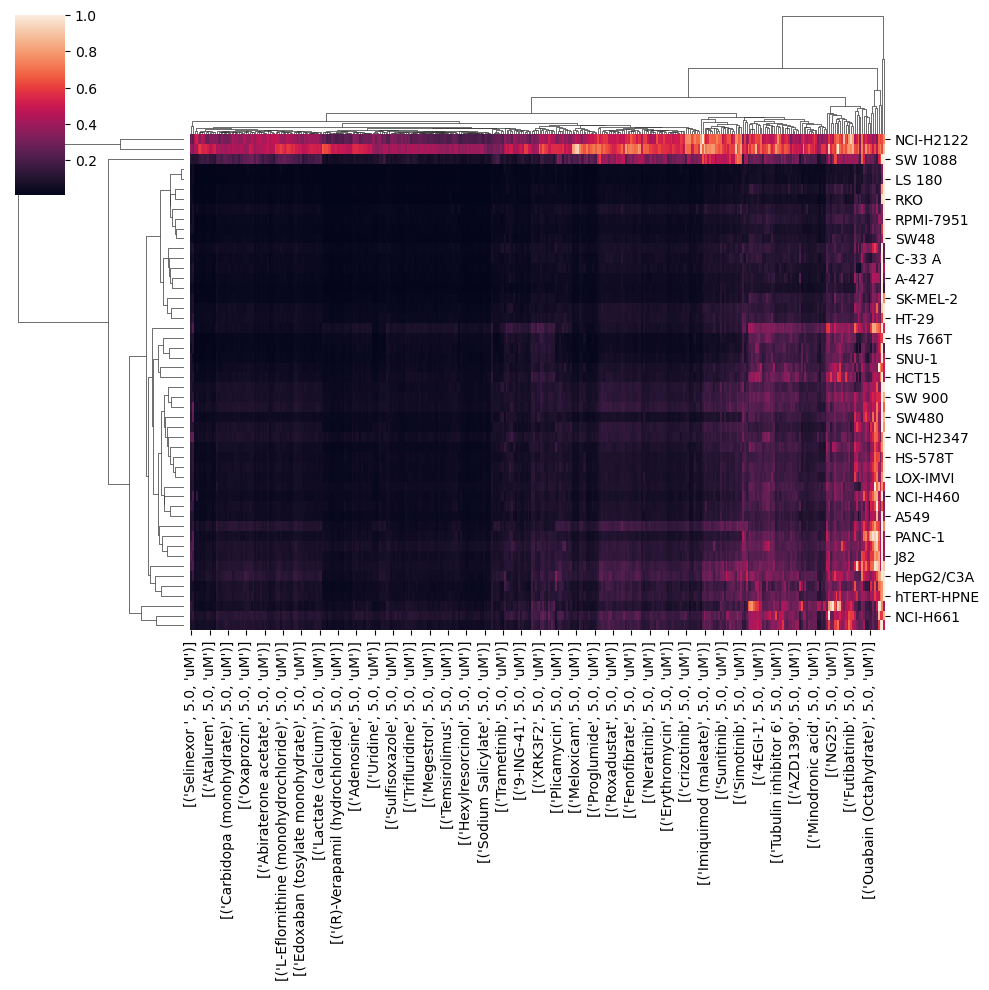

In [43]:
sns.clustermap(mse5)

/tmp/ipykernel_78768/3121223077.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/3121223077.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/3121223077.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/3121223077.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/3121223077.py:8: UserWarning: set_ticklabel

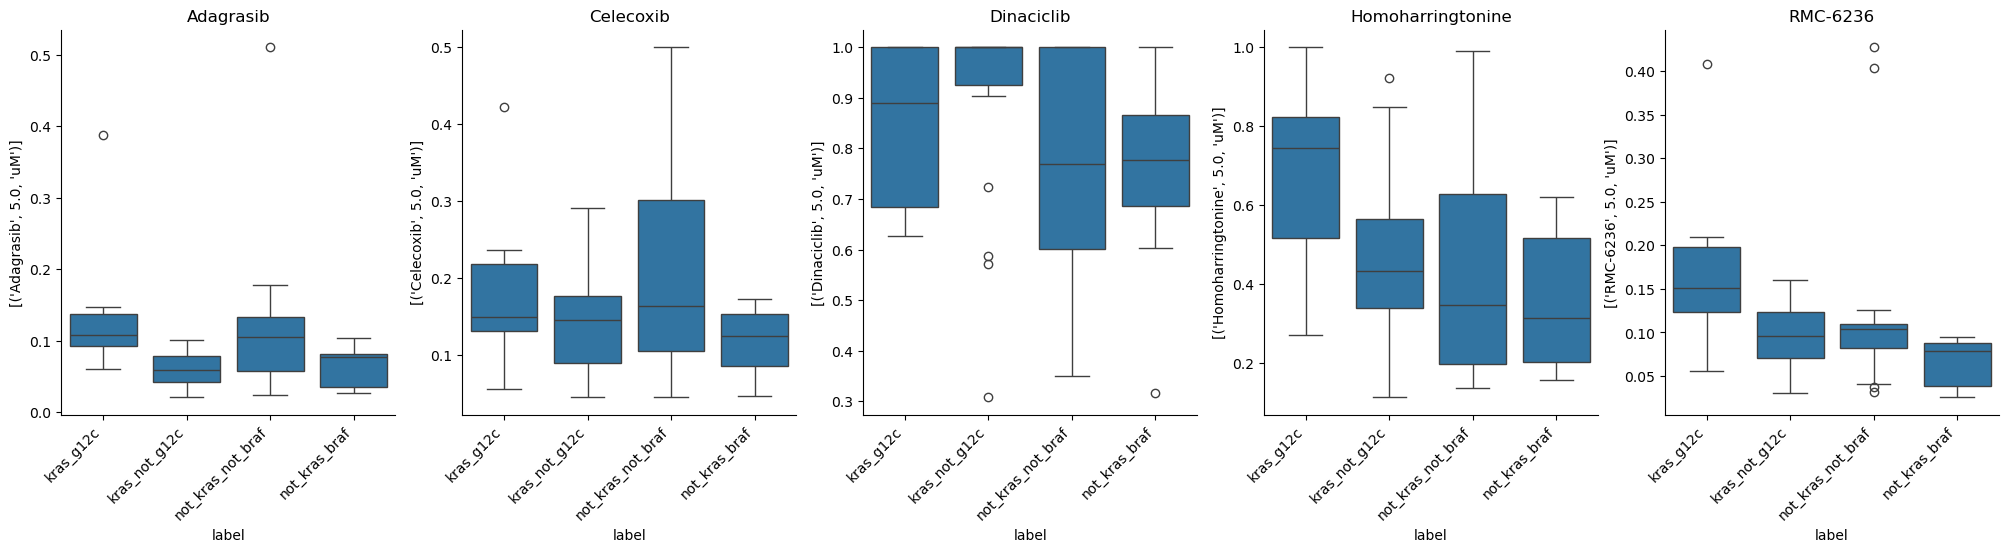

In [57]:
order = ['kras_g12c', 'kras_not_g12c', 'not_kras_not_braf', 'not_kras_braf']

nplot = len(picked_drugs)
fig, axs = plt.subplots(1, nplot, figsize=(nplot*5, 5))
sns.despine()
for drug, ax in zip(picked_drugs, axs.flatten()):
	sns.boxplot(x=mse_meta['label'], y=mse5[drug], ax=ax, order=order)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
	# ax.set_title(drug)
	drug_name = drug_meta5.loc[drug, 'drug']
	ax.set_title(drug_name)

/tmp/ipykernel_78768/717979756.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/717979756.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/717979756.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/717979756.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_78768/717979756.py:7: UserWarning: set_ticklabels() s

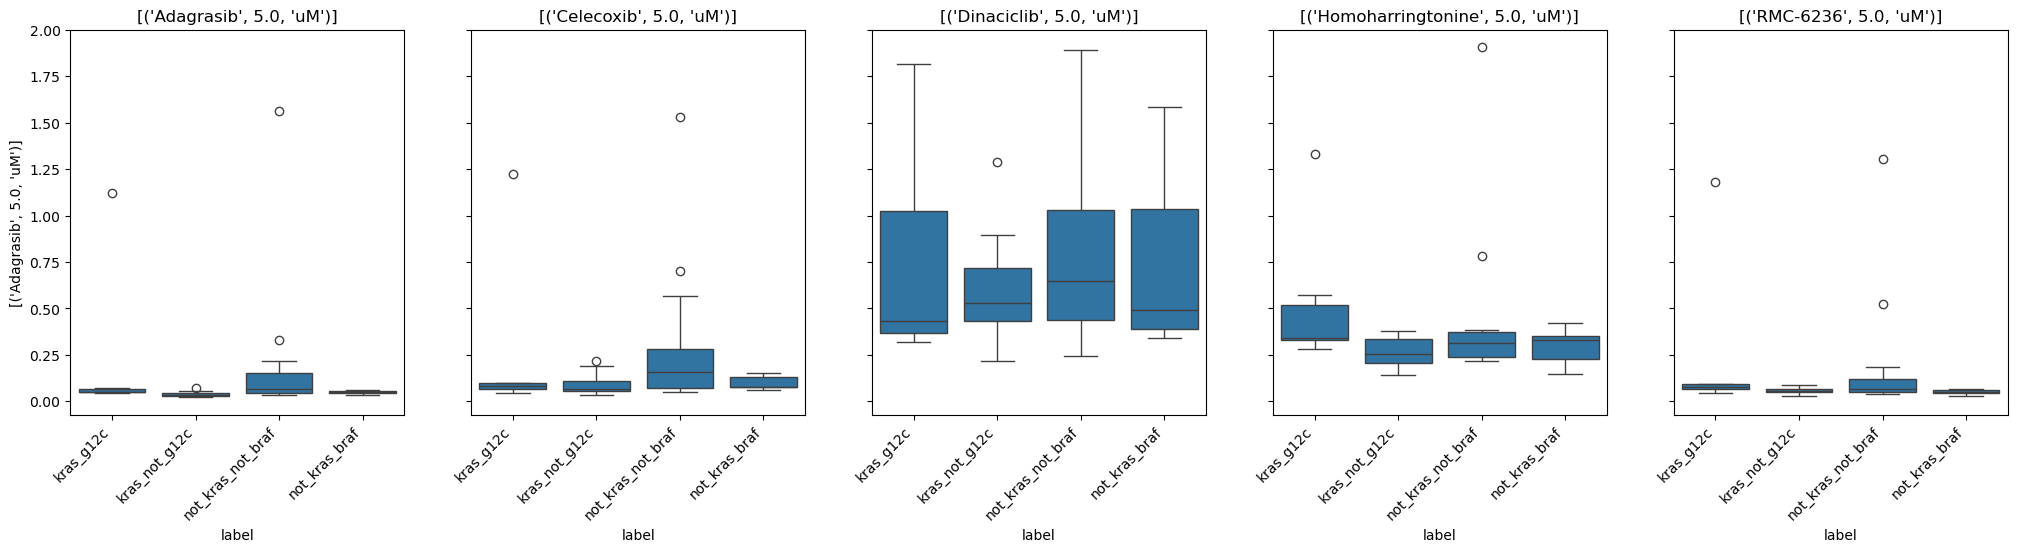

In [45]:
order = ['kras_g12c', 'kras_not_g12c', 'not_kras_not_braf', 'not_kras_braf']

nplot = len(picked_drugs)
fig, axs = plt.subplots(1, nplot, figsize=(nplot*5, 5), sharey=True)
for drug, ax in zip(picked_drugs, axs.flatten()):
	sns.boxplot(x=mse_meta['label'], y=msedf[drug], ax=ax, order=order)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
	ax.set_title(drug)